In [1]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [2]:
from pathlib import Path

import joblib
import numpy as np
import pandas as pd
import seaborn as sns
from keras import backend as K
from keras import applications, optimizers
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

import kfold_keras
from helper import filter_guided, plot_training_history, prepare_data

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

Using TensorFlow backend.


# Transfer learning ImageNet models
In this notebook we used ImageNet models on the Statoil dataset. Based on the size of the images only those models from keras which can directly accept the data without upscaling it. This means VGG16, VGG19 and Xception.

Only the best data pretreatment from the experiences with the simpler CNN was used: Guided prefiltering and no image scaling.

This was a two stage process:
1. The dataset was run through the pretrained Models, with out the top fully connected layer to calculate the *bottleneck features*. These were then used to train a new fully connected layer that has the desired binary output characteristics.
2. Again starting with the pretrained models, the last convoltional block was made trainable and the trained model from step 1. was placed on top of the model. Then the model was trained on the dataset.

As in the CNN training we used k-fold crossvalidation with early stopping to determine the best model.

Which was the fine tuned VGG16:

`VGG16_fine_tune     :  Acc=90.8, Epi=40.2, ROC_AUC=0.969, vloss=0.234`

##  Load the data: Guided Prefilter, and no scaling

In [3]:
data_folder = Path("data")
train_file = data_folder / 'train.json'
test_file = data_folder / 'test.json'

train = pd.read_json(train_file) 
print('loaded training '+str(len(train)))

y=train['is_iceberg'].values ## convert pandas series to numpy array
X=prepare_data(train,dim=[0,1,2],filter_function=filter_guided,rnd=False,scale=None)
input_shape= X[0].shape


loaded training 1604


## Transfer learning
This is the first step training a fully connected layer using the bottleneck features of the ImageNet models  as input

### VGG16 Bottleneck features


In [4]:
model = applications.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
print('Model loaded.')

bottleneck_features_train = model.predict(X)

model = Sequential()
model.add(Flatten(input_shape=bottleneck_features_train.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adadelta',loss='binary_crossentropy',metrics=['accuracy'])

out = kfold_keras.k_fold_keras_early_stop(model,bottleneck_features_train,y,k=5,
                                          name='VGG16_bottle',train_at_end=False,patience=20)


Model loaded.


VGG16_bottle        : 100%|██████████| 5/5 [00:07<00:00,  1.46s/it, Acc=74.5, Epi=47, ROC_AUC=0.89, vloss=0.586] 


In [5]:
model.save_weights('VGG16_bottle.h5')


Saved the last of the CV trained model to init the top model, below

###  Xception Bottleneck features

In [6]:
model = applications.Xception(weights='imagenet', include_top=False, input_shape=input_shape)
print('Model loaded.')

bottleneck_features_train = model.predict(X)

model = Sequential()
model.add(Flatten(input_shape=bottleneck_features_train.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adadelta',loss='binary_crossentropy',metrics=['accuracy'])


out = kfold_keras.k_fold_keras_early_stop(model,bottleneck_features_train,y,k=5,
                                          name='Xception_bottle',train_at_end=False,patience=20)


Model loaded.


Xception_bottle     : 100%|██████████| 5/5 [00:19<00:00,  4.10s/it, Acc=50.5, Epi=28.6, ROC_AUC=0.536, vloss=14.8]


In [7]:
model.save_weights('Xception_bottle.h5')

Saved the last of the CV trained model to init the top model, below

###  VGG19 Bottleneck features

In [8]:

model = applications.VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
print('Model loaded.')

bottleneck_features_train = model.predict(X)

model = Sequential()
model.add(Flatten(input_shape=bottleneck_features_train.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adadelta',loss='binary_crossentropy',metrics=['accuracy'])


out = kfold_keras.k_fold_keras_early_stop(model,bottleneck_features_train,y,k=5,
                                          name='VGG19_bottle',train_at_end=False,patience=20)


Model loaded.


VGG19_bottle        : 100%|██████████| 5/5 [00:07<00:00,  1.49s/it, Acc=74.8, Epi=43, ROC_AUC=0.876, vloss=0.57]   


In [9]:
model.save_weights('VGG19_bottle.h5')

Saved the last of the CV trained model to init the top model, below

## Fine tuning 

This is the second step, where we fine tune the last convolutional block and the top fully connected layers. It is crucial for the retraining of the convolutional block that we use the trained top model from the last step. As the strong gradients from a randomly initialised layer would destroy the pretrained weights.


### VGG16 fine tuning the last convolutional layers

As a first preliminary step, we fine tuned the model with just one validation set

following the procedure outlined here:

1.Chollet, F. Building powerful image classification models using very little data. Available at: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html. (Accessed: 9th July 2018)


In [4]:
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.3, random_state=42, stratify=y)
print(f'Training data: {X_train.shape}, with {y_train.shape} labels.')
print(f'Validation data: {X_val.shape}, with {y_val.shape} labels.')

Training data: (1122, 75, 75, 3), with (1122,) labels.
Validation data: (482, 75, 75, 3), with (482,) labels.


In [14]:
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# build a classifier model to put on top of the convolutional model
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))

# note that it is necessary to start with a fully-trained
# classifier, including the top classifier,
# in order to successfully do fine-tuning
top_model.load_weights('VGG16_bottle.h5')

# add the model on top of the convolutional base
model = Model(inputs= base_model.input, outputs= top_model(base_model.output))

# set the first 25 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in model.layers[:15]:
    layer.trainable = False
    
# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=5e-6, momentum=0.9),
              metrics=['accuracy'])


In [15]:
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16_fine_tune.hdf5', 
                               verbose=0, save_best_only=True)
training = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                                  epochs=50, batch_size=128, callbacks=[checkpointer], verbose=2)    

Train on 1122 samples, validate on 482 samples
Epoch 1/50
 - 1s - loss: 0.3311 - acc: 0.8360 - val_loss: 0.3129 - val_acc: 0.8714
Epoch 2/50
 - 1s - loss: 0.2563 - acc: 0.8841 - val_loss: 0.2792 - val_acc: 0.8921
Epoch 3/50
 - 1s - loss: 0.2525 - acc: 0.8948 - val_loss: 0.2811 - val_acc: 0.8880
Epoch 4/50
 - 1s - loss: 0.2464 - acc: 0.8904 - val_loss: 0.2775 - val_acc: 0.8900
Epoch 5/50
 - 1s - loss: 0.2491 - acc: 0.8904 - val_loss: 0.2787 - val_acc: 0.8859
Epoch 6/50
 - 1s - loss: 0.2411 - acc: 0.8939 - val_loss: 0.2798 - val_acc: 0.8880
Epoch 7/50
 - 1s - loss: 0.2444 - acc: 0.8904 - val_loss: 0.2782 - val_acc: 0.8880
Epoch 8/50
 - 1s - loss: 0.2348 - acc: 0.9029 - val_loss: 0.2743 - val_acc: 0.8942
Epoch 9/50
 - 1s - loss: 0.2222 - acc: 0.9198 - val_loss: 0.2727 - val_acc: 0.8921
Epoch 10/50
 - 1s - loss: 0.2333 - acc: 0.9064 - val_loss: 0.2717 - val_acc: 0.8921
Epoch 11/50
 - 1s - loss: 0.2302 - acc: 0.9064 - val_loss: 0.2711 - val_acc: 0.8921
Epoch 12/50
 - 1s - loss: 0.2285 - acc

Using a smooth window of 3


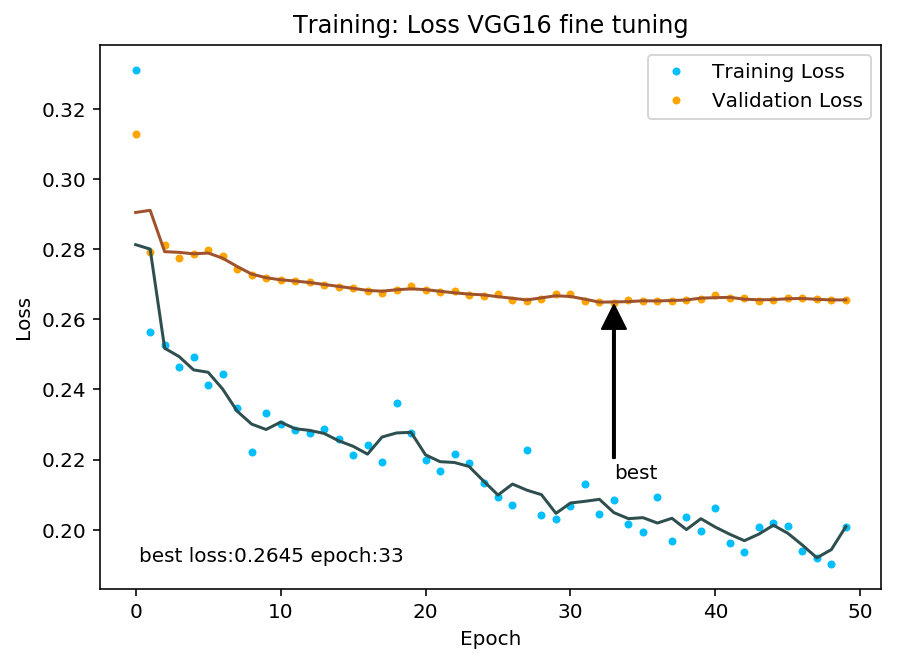

In [16]:
plot_training_history(training.history,'VGG16 fine tuning')

In [19]:
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# build a classifier model to put on top of the convolutional model
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))

# note that it is necessary to start with a fully-trained
# classifier, including the top classifier,
# in order to successfully do fine-tuning
top_model.load_weights('VGG16_bottle.h5')

# add the model on top of the convolutional base
model = Model(inputs= base_model.input, outputs= top_model(base_model.output))

# set the first 25 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in model.layers[:15]:
    layer.trainable = False
    
# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=5e-6, momentum=0.9),
              metrics=['accuracy'])


In [20]:
out = kfold_keras.k_fold_keras_early_stop(model,X,y,k=5,name='VGG16_fine_tune',epochs=200,
                                          batch_size=128,train_at_end=False,patience=20)

VGG16_fine_tune     : 100%|██████████| 5/5 [03:31<00:00, 43.47s/it, Acc=90.8, Epi=40.2, ROC_AUC=0.969, vloss=0.234]


### Xception Fine tuning

In [21]:
base_model = applications.Xception(weights='imagenet', include_top=False, input_shape=input_shape)

# build a classifier model to put on top of the convolutional model
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))

# note that it is necessary to start with a fully-trained
# classifier, including the top classifier,
# in order to successfully do fine-tuning
top_model.load_weights('Xception_bottle.h5')

# add the model on top of the convolutional base
model = Model(inputs= base_model.input, outputs= top_model(base_model.output))

# set the first 25 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in model.layers[:len(model.layers)-7]:
    layer.trainable = False
    
# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=5e-6, momentum=0.9),
              metrics=['accuracy'])

In [22]:
out = kfold_keras.k_fold_keras_early_stop(model,X,y,k=5,name='Xception_fine_tune',epochs=200,
                                          batch_size=128,train_at_end=False,patience=20)

Xception_fine_tune  : 100%|██████████| 5/5 [02:06<00:00, 25.34s/it, Acc=46.9, Epi=21, ROC_AUC=0.5, vloss=18.3]


### VGG19 Fine tuning

In [23]:
base_model = applications.VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

# build a classifier model to put on top of the convolutional model
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))

# note that it is necessary to start with a fully-trained
# classifier, including the top classifier,
# in order to successfully do fine-tuning
top_model.load_weights('VGG19_bottle.h5')

# add the model on top of the convolutional base
model = Model(inputs= base_model.input, outputs= top_model(base_model.output))

# set the first 25 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in model.layers[:17]:
    layer.trainable = False
    
# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=5e-6, momentum=0.9),
              metrics=['accuracy'])

In [24]:
out = kfold_keras.k_fold_keras_early_stop(model,X,y,k=5,name='VGG19_fine_tune',epochs=200,batch_size=128,
                                          train_at_end=False,patience=20)

VGG19_fine_tune     : 100%|██████████| 5/5 [02:54<00:00, 35.86s/it, Acc=90, Epi=28.8, ROC_AUC=0.964, vloss=0.249]  
